In [28]:
import json
import string
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [29]:
# descargaremos un pipeline de pre-procesamiento de SpaCy en español
!python -m spacy download es_core_news_sm

2023-09-07 19:11:21.425999: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 24.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [30]:
# cargar pipeline de pre-procesamiento en español
import spacy
nlp = spacy.load("es_core_news_sm")

In [114]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):
    # sacar tildes de las palabras:
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # [^ : ningún caracter de todos estos
    # (termina eliminando cualquier caracter distinto de los del regex)
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

In [115]:
text = "personas Ideas! estás cosas y los peces y los murciélagos"

# Antes de preprocesar los datos se pasa a minúsculas todo el texto
preprocess_clean_text(text.lower())

'personas ideas estas cosas y los peces y los murcielagos'

In [116]:
# Ejemplo de como funciona
text = "hola personas Ideas! estás cosas y los peces y los murciélagos"

# Antes de preprocesar los datos se pasa a minúsculas todo el texto
tokens = nlp(preprocess_clean_text(text.lower()))
print("tokens:", tokens)
print("Lematización de cada token:")
for token in tokens:
    print([token, token.lemma_])

tokens: hola personas ideas estas cosas y los peces y los murcielagos
Lematización de cada token:
[hola, 'holar']
[personas, 'persona']
[ideas, 'idea']
[estas, 'este']
[cosas, 'cosa']
[y, 'y']
[los, 'el']
[peces, 'pez']
[y, 'y']
[los, 'el']
[murcielagos, 'murcielago']


In [117]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
# Los "patterns" van a formar el corpus para entrenar el clasificador que clasifica en tags
# "respones" son las respuestas predeterminadas posibles para cada tag
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "Hola, ¿Estas?", "¿Cómo estás?", "¿Qué tal?", "Buenas"],
              "responses": ["Hola! Bienvinido a MedicOnline. ¿En que te puedo ayudar?", "Bienvenido a MedicOnline. ¿En que te puedo ayudar?"],
             },
             {"tag": "agendar",
              "patterns": ["Programar cita", "Programar", "Quisiera programar una cita", "cita"],
              "responses": ["¿Para cuando quieres tu cita?"],
             },
             {"tag": "programadas",
              "patterns": ["¿Tengo citas programadas?", "Quisiera conocer el estado de mi cita", "Estado de mi cita"],
              "responses": ["Buscando citas programadas...", "No se encontraron citas programadas"],
             },
             {"tag": "urgencias",
              "patterns": ["emergencia", "urgencia", "sos", "ayuda", "accidente"],
              "responses": ["Envíe su ubicación y una ambulancia andará en camino"],
             },
             {"tag": "contacto",
              "patterns": ["Necesito contactarme", "contacto", "contactar a un doctor"],
              "responses": ["Enseguida lo derivaremos con un doctor de urgencias..."],
             },
             {"tag": "despedida",
              "patterns": ["Muchas gracias", "Gracias", "Hasta luego", "Adios", "Ok"],
              "responses": ["Hasta Luego!", "Que te mejores!"],
             },

]}

In [118]:
# Datos que necesitaremos, las palabras o vocabulario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterizan
# a esa intención y transformarla a tokens para almacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)
# En `words` vamos a guardar el vocabulario
# En `class` las posibles clases o tags

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:
            words.append(token.lemma_)

        doc_X.append(pattern)
        doc_y.append(intent["tag"])

    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocabulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [119]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['a', 'accidente', 'adio', 'ayuda', 'buena', 'cita', 'como', 'conocer', 'contactar', 'contactarme', 'contacto', 'de', 'doctor', 'el', 'emergencia', 'estado', 'este', 'gracia', 'gracias', 'hasta', 'holar', 'luego', 'mi', 'mucho', 'necesitar', 'ok', 'programado', 'programar', 'que', 'querer', 'so', 'tal', 'tener', 'uno', 'urgencia']
classes: ['agendar', 'bienvenida', 'contacto', 'despedida', 'programadas', 'urgencias']
doc_X: ['Hola', 'Hola, ¿Estas?', '¿Cómo estás?', '¿Qué tal?', 'Buenas', 'Programar cita', 'Programar', 'Quisiera programar una cita', 'cita', '¿Tengo citas programadas?', 'Quisiera conocer el estado de mi cita', 'Estado de mi cita', 'emergencia', 'urgencia', 'sos', 'ayuda', 'accidente', 'Necesito contactarme', 'contacto', 'contactar a un doctor', 'Muchas gracias', 'Gracias', 'Hasta luego', 'Adios', 'Ok']
doc_y: ['bienvenida', 'bienvenida', 'bienvenida', 'bienvenida', 'bienvenida', 'agendar', 'agendar', 'agendar', 'agendar', 'programadas', 'programadas', 'programadas

In [120]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))
# Cantidad de tags
print("Tags:", len(classes))

Vocabulario: 35
Tags: 6


In [121]:
# llevo los tokens del corpus completo para luego aplicar TF-IDF
text_test = []
for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
      text_test.append(token.lemma_)
print(text_test)

['holar', 'holar', 'este', 'como', 'este', 'que', 'tal', 'buena', 'programar', 'cita', 'programar', 'querer', 'programar', 'uno', 'cita', 'cita', 'tener', 'cita', 'programado', 'querer', 'conocer', 'el', 'estado', 'de', 'mi', 'cita', 'estado', 'de', 'mi', 'cita', 'emergencia', 'urgencia', 'so', 'ayuda', 'accidente', 'necesitar', 'contactarme', 'contacto', 'contactar', 'a', 'uno', 'doctor', 'mucho', 'gracia', 'gracias', 'hasta', 'luego', 'adio', 'ok']


In [122]:
# Transformar doc_X en bag of words por TF-IDF
# Transformar doc_Y en un vector de clases multicategórico con OneHotEncoding
from math import log

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
      text.append(token.lemma_)

    bow = []
    idf_terms = []
    corpus_size = len(doc_X)
    # Transformar los tokens en "Bag of words"
    for word in words:
      # IDF
      [idf_terms.append(word) for docs in text_test if word in docs]
      idf_values = len([count for count, value in enumerate(idf_terms) if value == word])
      idf = log(corpus_size / idf_values)
      # TF-IDF
      if word not in text:
        bow.append(0 * idf) # si no existe colocamos 0
      else:
        # buscamos cuantas veces se repite el termino en el documento
        num_obs = len([count for count, value in enumerate(text) if value == word])
        bow.append(num_obs * idf)

    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [-0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5257286443082556, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] y: [0, 1, 0, 0, 0, 0]
X: [-0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5257286443082556, 0.0, 0.0, 0.0, 2.5257286443082556, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] y: [0, 1, 0, 0, 0, 0]
X: [-0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.2188758248682006, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5257286443082556, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] y: [0, 1, 0, 0, 0, 0]
X: [-0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.120263536200091, 0.0, 0.0, 3.2188758248682006, 0.0, 0.0, 0.0] y: [0, 1, 0, 0, 0, 0]
X: [-0.0, 0.0, 0.0, 0.0, 3.2188758248682006, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [123]:
log(len(doc_X)/1)

3.2188758248682006

In [124]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (35,) output: 6


In [125]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(64, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                2304      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 6)                 198       
                                                                 
Total params: 4,582
Trainable params: 4,582
Non-trainable params: 0
_________________________________________________________________
None


In [126]:
hist = model.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200
1/1 [==============================] - 1s 921ms/step - loss: 1.9706 - accuracy: 0.1200
Epoch 2/200
1/1 [==============================] - 0s 15ms/step - loss: 2.0333 - accuracy: 0.0400
Epoch 3/200
1/1 [==============================] - 0s 19ms/step - loss: 1.7749 - accuracy: 0.2800
Epoch 4/200
1/1 [==============================] - 0s 22ms/step - loss: 1.8904 - accuracy: 0.1200
Epoch 5/200
1/1 [==============================] - 0s 19ms/step - loss: 1.8489 - accuracy: 0.2000
Epoch 6/200
1/1 [==============================] - 0s 12ms/step - loss: 1.5428 - accuracy: 0.2000
Epoch 7/200
1/1 [==============================] - 0s 17ms/step - loss: 1.8034 - accuracy: 0.2000
Epoch 8/200
1/1 [==============================] - 0s 16ms/step - loss: 1.9304 - accuracy: 0.1600
Epoch 9/200
1/1 [==============================] - 0s 12ms/step - loss: 2.1852 - accuracy: 0.1600
Epoch 10/200
1/1 [==============================] - 0s 14ms/step - loss: 1.6888 - accuracy: 0.2000
Epoch 11/200
1/1 [

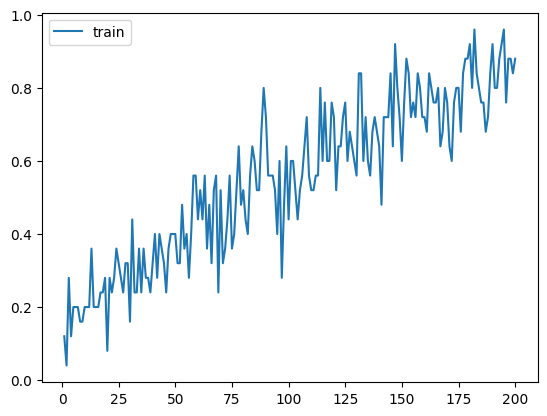

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [128]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# En NLP además de los modelos es necesario proveer: tokenizador y vocabulario.
# La tríada modelo+tokenizador+vocabulario es necesaria para hacer inferencia.
# Sin una de las tres no se puede hacer inferencia.

# en este caso guardamos:
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

In [129]:
# convertir texto de entrada del usuario a tokens
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

# transformar el texto de entrada tokenizado a una representación OHE
def bag_of_words(text, vocab):
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens:
        for idx, word in enumerate(vocab):
            if word == w:
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

# usar modelo con la entrada en OHE y los labels posibles (tags)
def pred_class(text, vocab, labels):
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0: # sólo si reconoció alguna palabra del vocabulario
        result = model.predict(np.array([bow]))[0] # es un array de softmax
        thresh = 0.2
        # filtrar aquellas entradas menores al umbral `thresh`
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # ordenar keys de acuerdo al valor softmax
        y_pred.sort(key=lambda x: x[1], reverse=True)

        # return_list es una lista de los labels de mayor a menor
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    # si no reconoció palabras del vocabulario se devuelve una lista vacía
    return return_list

# obtener una respuesta predeterminada
def get_response(intents_list, intents_json):
    tag = intents_list[0] # tomar el tag con el mejor valor softmax
    list_of_intents = intents_json["intents"] # intents_json es todo el dataset
    for i in list_of_intents:
        if i["tag"] == tag: # buscar el tag correspoindiente y dar una respuesta predeterminada aleatoria
            result = random.choice(i["responses"])
            break
    return result

In [131]:
while True:
    # pedir input al usuario
    message = input("")
    print("Q:", message)

    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print("BOT:", result)
    else: # si no hubo ningún resultado que supere el umbral
        print("BOT: Perdón, no comprendo la pregunta.")
        break

hola
Q: hola
1/1 [==============================] - 0s 26ms/step
BOT: Bienvenido a MedicOnline. ¿En que te puedo ayudar?
tengo alguna cita programada?
Q: tengo alguna cita programada?
1/1 [==============================] - 0s 27ms/step
BOT: No se encontraron citas programadas
me gustaría programar una cita
Q: me gustaría programar una cita
1/1 [==============================] - 0s 33ms/step
BOT: ¿Para cuando quieres tu cita?
realmente tengo una urgencia
Q: realmente tengo una urgencia
1/1 [==============================] - 0s 29ms/step
BOT: Hola! Bienvinido a MedicOnline. ¿En que te puedo ayudar?
tengo una emergencia
Q: tengo una emergencia
1/1 [==============================] - 0s 24ms/step
BOT: Envíe su ubicación y una ambulancia andará en camino
me puedo contactar con un doctor
Q: me puedo contactar con un doctor
1/1 [==============================] - 0s 26ms/step
BOT: Enseguida lo derivaremos con un doctor de urgencias...
gracias
Q: gracias
1/1 [==============================] - 0s

**Analsis**

Como se puede observar, se implementó el mismo bot hecho en clases, pero usando un dataset distinto que simulaba un bot medico. Si bien contactaba a emergencias por ti, tambien podía agendar citas, etc.

La vectorización que se utilizo durante el pre-procesamiento fue TF-IDF a diferencia del bot original que utilizaba OneHotEncoder. El cambio de vectorización no afecto notablemente en el rendimiento del bot.

Por otro lado, según la prueba conversacional hecha anteriormente, es notable que el modelo es capaz de encontrar la clase correcta cuando se utilizan palabras que se repiten varias veces en el patron. Por ejemplo:

en la pregunta que le hace el usuario: "realmente tengo una urgencia", el bot no es capaz de distinguir con precisión en esta oportunidad la clase correcta. Puede que se deba a que solo una de las palabras en la oración era relevante para distinguir la frase.

En general, el bot siguió siendo bastante preciso, tambíen se disminuyó la cantidad de neuronas de la red neuronal, pero al ser un dataset tan pequeño la red sigue funcionando bastante bien.